In [ ]:
from random import seed
seed(42)
from numpy.random import seed as np_seed
np_seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
from tensorflow import keras
from keras import activations
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing import image
from keras.layers import *
from keras.models import Sequential, Model

x_train shape : (50000, 32, 32, 3)
x_test shape : (10000, 32, 32, 3)
y_train shape : (50000, 10)
y_test shape : (10000, 10)


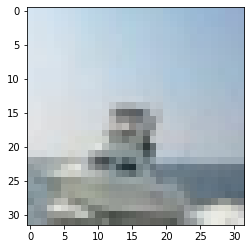

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print('x_train shape :', x_train.shape)
print('x_test shape :',x_test.shape)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

input_size = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

plt.imshow(x_train[100])
plt.show()

In [ ]:
#GAN에서 generator와 discriminator를 구현할 때 필요한 기법들이 있다. generator의 마지막 layer의 activation function은 softmax나 sigmoid가 아닌 tanh를 쓰는 것 등

input = Input(input_size[1], name='InputLayer')

l = Dense(128 * 16 * 16, activation='LeakyReLU')(input)
l = Reshape((16, 16, 128))(l)

l = Conv2D(128, 5, padding='same', activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.8)(l)

# l = UpSampling2D()(l)
l = Conv2DTranspose(256, 7, strides = 2, padding = 'same')(l)
l = Conv2D(256, 5, padding='same', activation='LeakyReLU')(l)
# b2 = BatchNormalization(momentum=0.8)(c2)

# l = Conv2D(64, 5, padding='same', activation='LeakyReLU')(l)
# l = UpSampling2D()(l)
# l = Conv2DTranspose(128, 5, padding='same', activation='LeakyReLU')(l)
l = Conv2D(128, 5 ,padding='same', activation='LeakyReLU')(l)
l = Conv2D(128, 5, padding='same', activation='LeakyReLU')(l)
l = Conv2D(x_train.shape[3], 5, padding='same', activation='tanh')(l)

G = Model(inputs=input, outputs=l, name='generator')

G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_13 (Dense)            (None, 32768)             1081344   
                                                                 
 reshape_6 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)       409728    
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 256)      1605888   
 ranspose)                                                       
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 256)       1638656   
                                                         

In [ ]:
input = Input(shape=input_size)

l = Conv2D(32*2, 4, activation='LeakyReLU')(input)
# l = BatchNormalization(momentum=0.9)(l)
l = Dropout(0.25)(l)

l = Conv2D(32*2, 4, activation='LeakyReLU')(l)
l = Dropout(0.25)(l)

l = Conv2D(32*4, 4, activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.9)(l)
l = Dropout(0.25)(l)

l = Conv2D(32*4, 4, activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.9)(l)
l = Dropout(0.25)(l)

# l = Conv2D(32*16, 3, activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.9)(l)

l = Flatten()(l)
# l = Dense(256, activation='relu')(l)
# l = Dense(128, activation='relu')(l)
# l = Dense(64, activation='relu')(l)
# l = Dense(32, activation='relu')(l)
l = Dropout(0.25)(l)
l = Dense(1, activation='softmax')(l)

D = Model(inputs=input, outputs=l, name='discriminator')

D.summary()

D_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
D.compile(loss='binary_crossentropy', optimizer=D_optimizer, metrics=['accuracy'])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 29, 29, 64)        3136      
                                                                 
 dropout_35 (Dropout)        (None, 29, 29, 64)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 26, 26, 64)        65600     
                                                                 
 dropout_36 (Dropout)        (None, 26, 26, 64)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 23, 23, 128)       131200    
                                                                 
 dropout_37 (Dropout)        (None, 23, 23, 128)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#input = 임의로 생성한 sample
#output = 임의로 생성한 sample을 generator에 넣은 것(fake image)를 discriminator가 판별한 결과
#gan은 판별자가 가짜이미지를 진짜라고 판별하도록 학습하는 것이 목표
noise = Input(shape=(input_size[1],))
gan = Model(inputs=noise, outputs=D(G(noise)))
gan.summary()

#discriminator는 훈련. gan에서는 가중치 업데이트 X
#gan에서의 판별자는 진짜라고 판별하도록 하고 싶기 때문에 discriminator가 여기서 학습이 되면 학습이 이상하게 진행됨
D.trainable = False

gan_optimizer = keras.optimizers.Adam(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32)]              0         
                                                                 
 generator (Functional)      (None, 32, 32, 3)         5974275   
                                                                 
 discriminator (Functional)  (None, 1)                 513409    
                                                                 
Total params: 6,487,684
Trainable params: 6,487,684
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 20
iterations = 1000
latent_dim = 32

random_vectors : (20, 32)
generated_images : (20, 32, 32, 3)
real_images: (20, 32, 32, 3)
discriminator loss at step 0 : [0.7000163197517395, 0.0]
gan loss at step 0 : 0.6263697147369385
discriminator loss at step 100 : [0.4848608076572418, 0.0]
gan loss at step 100 : 2.2350776195526123
discriminator loss at step 200 : [0.7186011075973511, 0.0]
gan loss at step 200 : 1.9082435369491577
discriminator loss at step 300 : [0.8190408945083618, 0.0]
gan loss at step 300 : 2.497631072998047
discriminator loss at step 400 : [0.7606159448623657, 0.0]
gan loss at step 400 : 2.4965741634368896
discriminator loss at step 500 : [0.781427264213562, 0.0]
gan loss at step 500 : 3.575305461883545
discriminator loss at step 600 : [0.33102524280548096, 0.0]
gan loss at step 600 : 1.8508933782577515
discriminator loss at step 700 : [0.37011268734931946, 0.0]
gan loss at step 700 : 1.7043936252593994
discriminator loss at step 800 : [0.5449371337890625, 0.0]
gan loss at step 800 : 3.2210757732391357
discri

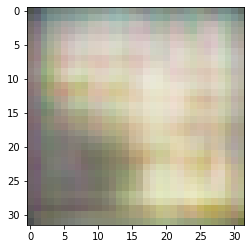

In [ ]:
with tf.device('/device:GPU:0'):
  start = 0
  for step in range(iterations):
      #batch size 개수 만큼의 normal distribution(정규분포)로 (batch_size, laten_dim)크기를 가진 random sample 생성
      random_vectors = np.random.normal(size=(batch_size, latent_dim))
      if step == 0: print('random_vectors :', random_vectors.shape)

      #random sample을 generator에 넣어 decoding
      generated_images = G.predict(random_vectors)
      if step == 0: print('generated_images :', generated_images.shape)

      #batch size 만큼의 real image를 generator로 decoding한 image와 합침
      stop = start + batch_size
      real_images = x_train[start: stop]
      if step == 0:
        print('real_images:', real_images.shape)
        print('=' * 50)
      
      combined_images = np.concatenate([generated_images, real_images])

      #decoding image(fake image)와 real image의 개수만큼의 0, 1로 이루어진 label 생성
      labels = np.concatenate([np.ones((batch_size, 1)),
                              np.zeros((batch_size, 1))])
      
      #(랜덤한 0~1 균일분포) * 0.05 값을 더해 label 업데이트
      #왜지?
      labels += 0.05 * np.random.random(labels.shape)

      #fake와 real이 섞인 image들과 업데이트된 label을 갖고 discriminator training
      d_loss = D.train_on_batch(combined_images, labels)

      #또다른 random sample 생성
      random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

      #misleading(오해의 소지가 있는)
      #batch size만큼의 0으로 이루어진 misledaing한 target 생성
      misleading_targets = np.zeros((batch_size, 1))
     
      #또다른 fake image는 거짓(0)이라고 gan training
      a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
      
      #batch size만큼을 방금 사용했으니 start point 업데이트
      #if문을 통해 range를 초과하는 index error 방지
      start += batch_size
      if start > len(x_train) - batch_size:
        start = 0

      #100번 진행할 때마다 process 시각화
      #gan이 생성한 imgae 하나를 시각화
      if step % 100 == 0:
          # gan.save_weights('gan.h5')

          print('discriminator loss at step %s : %s' % (step, d_loss))
          print('gan loss at step %s : %s' % (step, a_loss))

          # # 생성된 이미지 하나를 저장합니다
          # img = image.array_to_img(generated_images[0] * 255., scale=False)
          # img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
          img = image.array_to_img(generated_images[0] * 255., scale=False)
          plt.imshow(img)

          # # 비교를 위해 진짜 이미지 하나를 저장합니다
          # img = image.array_to_img(real_images[0] * 255., scale=False)
          # img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

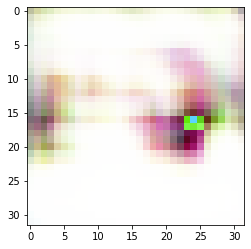

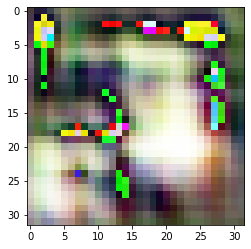

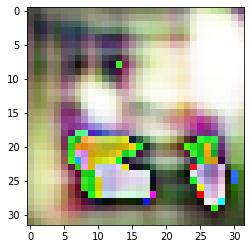

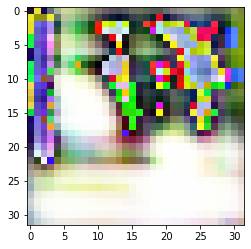

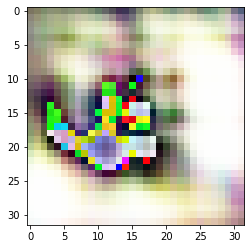

In [ ]:
random_latent_vectors = np.random.normal(size=(5, latent_dim))

# 가짜 이미지 디코딩
generated_images = G.predict(random_latent_vectors )

for i in range(generated_images.shape[0]):
  img = image.array_to_img(generated_images[i] * 255. , scale = False)
  plt.figure()
  plt.imshow(img)

plt.show()